# This colab notebook contains a demo of how FacetsLabeling can be used to label and create a small ML dataset that can be used to train a simple model.  

* Currently there are no open source data labeling tools that can work from a notebook.  
* This labeling tool will help you visualize and improve the quality of your ML datasets
* Directly visualize and find how your model is performing. 
* Correct mistakes in your labeled dataset and fix mislabeled examples. 
* Labeling helps you to make a balanced dataset. 


### Step 1: Downlaod and import FacetsLabeling library

In [39]:
!git clone https://github.com/jsiddique/facets_labeling.git

fatal: destination path 'facets_labeling' already exists and is not an empty directory.


In [40]:
!git clone https://github.com/Geotab/facets-demo.git

fatal: destination path 'facets-demo' already exists and is not an empty directory.


In [41]:
!pip install -q tfds-nightly tensorflow matplotlib

In [42]:
from os import sys
sys.path.append('./facets_labeling/')

In [38]:
import numpy as np
import pandas as pd
from PIL import Image
from facets_labeling import colab_dive
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
plt.ioff()

### Step 2: Download dataset and load in dataframe.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [10]:
ds, info = tfds.load('mnist', split='train', with_info=True)
df = tfds.as_dataframe(ds.take(10000), info)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Step 3: Only select one and zeros

In [11]:
num_examples = 400
height = 20
width = 20

In [12]:
df = df[(df.label == 1) | (df.label == 0)]
df = df.reset_index()
df = df[:num_examples]

In [13]:
X_test = np.array([x.reshape(28, 28) for x in df.image.values])  

In [14]:
#y_test = np.array(df.label.values)
df = df.drop(columns='label')

### Step 4: Stitch all the images in a sprite atlas
To understand the concept of sprite atlas visit [this link](https://github.com/PAIR-code/facets/tree/master/facets_dive).

In [15]:
import PIL.ImageOps 
def array_to_sprite_atlas(image_array, num_sprites_x, num_sprites_y):
    "Takes an array of images of shape (num_images, img_width, img_height) and splices them together to form a big ass mosaic (sprite atlas)."
    # Mnist arrays are in 0-1 range, PIL needs 0-255
    image_array = image_array * 1
    image_width, image_height = image_array.shape[1], image_array.shape[2]
    atlas_width  = num_sprites_x * image_width
    atlas_height = num_sprites_y * image_height
    # We paste the samples to get indices arranged in the following way:
    # | 0 | 1 | 2 | 3 |
    # | 4 | 5 | 6 | 7 |
    atlas  = Image.new("RGB", (atlas_width, atlas_height), (0, 0, 0))
    for i in range(num_sprites_y): 
        for j in range(num_sprites_x):
            sample = image_array[num_sprites_x * i + j, :, :]
            image = Image.fromarray(sample)
            atlas.paste(image, (j*image_width, i*image_height))
    return atlas
atlas = array_to_sprite_atlas(X_test.reshape(X_test.shape[0], 28, 28), height, width)
atlas = PIL.ImageOps.invert(atlas)
atlas.save("atlas.jpg")

In [16]:
# id_df only contains ids
id_df = pd.DataFrame()
id_list = [str(x) for x in range(num_examples)]
id_df['Id'] = id_list

### Step 5: Create facets visulization

In [72]:
import base64
labels = ['Zero', 'One']
with open("atlas.jpg", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
url_template = "data:image/png;base64,{encoded_string}"
from facets_labeling import colab_dive 
fc = colab_dive.Facets()
results = fc.create_classes(labels=labels)
fc.define_atlas(id_df, sprite_width=28, sprite_height=28, atlas_url=url_template.format(encoded_string=encoded_string.decode("utf-8")))
fc.render_html('mnist.html')

Reset Select Class Zero One
Zero: 0 One: 0 Total: 0
""

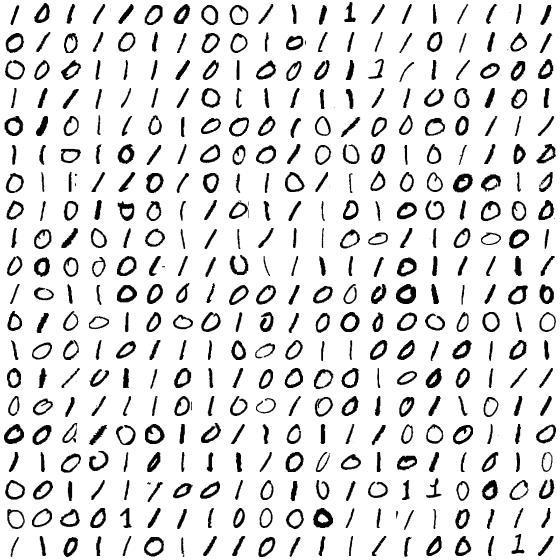

In [73]:
f = open('mnist.html', 'r')
t = f.read()
f.close()
from IPython.display  import HTML
display(HTML(t))

##### Instructions on how to label
* Click reset to clear the cache. (Don't need to clear the cache if you want to keep labeling that's already done)
* Click select class dropdown list to see the list of classes. Select the class you want to label.   
* Use shift+click to label instance 
* Click select class dropdown list and label another class

### Step 6: Download labeled data from browser cache and store them in a dictionary

In [59]:
label_dict = {}

In [60]:
# Don't put any other code in this cell. It runs javascript code in background
fc.create_labeled_variables(label_dict=label_dict)

<IPython.core.display.Javascript object>

In [61]:
label_dict

{'One': '374,375,335,131,198,303,162,81,53',
 'Zero': '360,361,363,223,226,233,325'}

In [62]:
# Inverse labelDict to eventDict
eventDict = {}
for key in label_dict.keys():
  labels = label_dict[key]
  eventIds = labels.split(',')
  for event in eventIds:
    eventDict[event] = key


In [63]:
#eventDict

In [64]:
# Add all the labels as a column in a dataframe
id_df['Labels'] = id_df.Id.apply(lambda x : eventDict[x] if x in eventDict else 'None')

### Step 7: Train a simple model using labels

In [65]:
# check distribution of the labels
id_df.Labels.value_counts()

None    384
One       9
Zero      7
Name: Labels, dtype: int64

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
df_train = df.copy()

In [68]:
df_train["Labels"] = id_df.Labels
df_train = df_train[df_train.Labels != 'None']

In [69]:
X_train = np.array([x.reshape(28*28) for x in df_train.image.values]) 
y_train = df_train.Labels.values

In [70]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
# make predictions using the trained model and save the results in the dataframe. 
predictions = model.predict(np.array([x.reshape(28*28) for x in df.image.values]))
id_df['Predictions'] = predictions

### Step 8: Go to step 5 and create the visualization and retrain the models again. 
* Thre will be a new column in the visualization called Predictions. 
* Select this column and check how the predictions looks like. 
* Fix mistakes by relabeling the examples
* Retrain the model using new fixed labels and visulize again. 